## TVP-VAR, MCMC, and sparse simulation smoothing

This notebook shows how to:

- Construct a time-varying parameters vector autoregression (TVP-VAR) model in Statsmodels
- Estimate the parameters of the TVP-VAR model using Bayesian methods (Gibbs sampling)
- Use the "Cholesky Factor Algorithm" approach (Chan and Jeliazjov, 2009) for state space simulation smoothing

**Table of Contents**:

1. [Background on simulation smoothing in state space models](#Background)
2. [Simulating smoothing in Statsmodels](#Implementation-in-Statsmodels)
3. [Constructing a TVP-VAR model in Statsmodels](#Application:-Bayesian-analysis-of-a-TVP-VAR-model-by-MCMC)
4. [Bayesian estimation of TVP-VAR by Gibbs Sampling](#Bayesian-estimation-via-MCMC)
5. [References](#References)

**Note**: the "Cholesky Factor Algorithm" (CFA) simulation smoother described in this notebook was implemented in Statsmodels v0.12. It is not available in v0.11 or below. However, the TVP-VAR model and MCMC estimation routine can be done in earlier Statsmodels versions, except without the `method='cfa'` argument.

### Background

Bayesian analysis of linear Gaussian state space models via Markov chain Monte Carlo (MCMC) methods has become both commonplace and relatively straightforward in recent years, due especially to advances in sampling from the joint posterior of the unobserved state vector conditional on the data and model parameters (see especially Carter and Kohn (1994), de Jong and Shephard (1995), and Durbin and Koopman (2002)). This is particularly useful for Gibbs sampling MCMC approaches.

While these procedures make use of the forward/backward application of the recursive Kalman filter and smoother, another recent line of research takes a different approach and constructs the posterior joint distribution of the entire vector of states at once - see in particular Chan and Jeliazkov (2009) for an econometric time series treatment and McCausland et al. (2011) for a more general survey. In particular, the posterior mean and precision matrix are constructed explicitly, with the latter a sparse band matrix. Advantage is then taken of efficient algorithms for Cholesky factorization of sparse band matrices; this reduces memory costs and can improve performance. Following McCausland et al. (2011), we refer to this method as the "Cholesky Factor Algorithm" (CFA) approach.

The CFA-based simulation smoother has some advantages and some drawbacks compared to that based on the more typical Kalman filter and smoother (KFS).

**Advantages of CFA**:

- Derivation of the joint posterior distribution is relatively straightforward and easy to understand.
- In some cases can be both faster and less memory-intensive than the KFS approach
    - In the Appendix at the end of this notebook, we briefly discuss the performance of the two simulation smoothers for the TVP-VAR model. In summary: simple tests on a single machine suggest that for the TVP-VAR model, the CFA and KFS implementations in Statsmodels have about the same runtimes, while both implementations are about twice as fast as the replication code, written in Matlab, provided by Chan and Jeliazkov (2009).

**Drawbacks of CFA**:

The main drawback is that this method has not (at least so far) reached the generality of the KFS approach. For example:

- It can not be used with models that have reduced-rank error terms in the observation or state equations.
    - One implication of this is that the typical state space model trick of including identities in the state equation to accommodate, for example, higher-order lags in autoregressive models is not applicable. These models can still be handled by the CFA approach, but at the cost of requiring a slightly different implementation for each lag that is included.
    - As an example, standard ways of representing ARMA and VARMA processes in state space form do include identities in the observation and/or state equations, and so the basic formulas presented in Chan and Jeliazkov (2009) do not apply immediately to these models.
- Less flexibility is available in the state initialization / prior.

In [1]:
%matplotlib inline

from importlib import reload
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.stats import invwishart, invgamma

# Get the macro dataset
dta = sm.datasets.macrodata.load_pandas().data
dta.index = pd.date_range('1959Q1', '2009Q3', freq='QS')

### Implementation in Statsmodels

A CFA simulation smoother along the lines of the basic formulas presented in Chan and Jeliazkov (2009) has been implemented in Statsmodels.

**Notes**:

- Therefore, the CFA simulation smoother in Statsmodels so-far only supports the case that the state transition is truly a first-order Markov process (i.e. it does not support a p-th order Markov process that has been stacked using identities into a first-order process).
- By contrast, the KFS smoother in Statsmodels is fully general any can be used for any state space model, including those with stacked p-th order Markov processes or other identities in the observation and state equations.

Either a KFS or the CFA simulation smoothers can be constructed from a state space model using the `simulation_smoother` method. To show the basic idea, we first consider a simple example.

#### Local level model

A local level model decomposes an observed series $y_t$ into a persistent trend $\mu_t$ and a transitory error component

$$
\begin{aligned}
y_t & = \mu_t + \varepsilon_t, \qquad \varepsilon_t \sim N(0, \sigma_\text{irregular}^2) \\
\mu_t & = \mu_{t-1} + \eta_t, \quad ~ \eta_t \sim N(0, \sigma_\text{level}^2)
\end{aligned}
$$

This model satisfies the requirements of the CFA simulation smoother because both the observation error term $\varepsilon_t$ and the state innovation term $\eta_t$ are non-degenerate - that is, their covariance matrices are full rank.

We apply this model to inflation, and consider simulating draws from the posterior of the joint state vector. That is, we are interested in sampling from

$$p(\mu^t \mid y^t, \sigma_\text{irregular}^2, \sigma_\text{level}^2)$$

where we define $\mu^t \equiv (\mu_1, \dots, \mu_T)'$ and $y^t \equiv (y_1, \dots, y_T)'$.

In Statsmodels, the local level model falls into the more general class of "unobserved components" models, and can be constructed as follows:

In [2]:
# Construct a local level model for inflation
mod = sm.tsa.UnobservedComponents(dta.infl, 'llevel')

# Fit the model's parameters (sigma2_varepsilon and sigma2_eta)
# via maximum likelihood
res = mod.fit()
print(res.params)

# Create simulation smoother objects
sim_kfs = mod.simulation_smoother()              # default method is KFS
sim_cfa = mod.simulation_smoother(method='cfa')  # can specify CFA method

sigma2.irregular    3.373368
sigma2.level        0.744712
dtype: float64


The simulation smoother objects `sim_kfs` and `sim_cfa` have `simulate` methods that perform simulation smoothing. Each time that `simulate` is called, the `simulated_state` attribute will be re-populated with a new simulated draw from the posterior.

Below, we construct 20 simulated paths for the trend, using the KFS and CFA approaches, where the simulation is at the maximum likelihood parameter estimates.

In [3]:
nsimulations = 20
simulated_state_kfs = pd.DataFrame(
    np.zeros((mod.nobs, nsimulations)), index=dta.index)
simulated_state_cfa = pd.DataFrame(
    np.zeros((mod.nobs, nsimulations)), index=dta.index)

for i in range(nsimulations):
    # Apply KFS simulation smoothing
    sim_kfs.simulate()
    # Save the KFS simulated state
    simulated_state_kfs.iloc[:, i] = sim_kfs.simulated_state[0]

    # Apply CFA simulation smoothing
    sim_cfa.simulate()
    # Save the CFA simulated state
    simulated_state_cfa.iloc[:, i] = sim_cfa.simulated_state[0]

Plotting the observed data and the simulations created using each method below, it is not too hard to see that these two methods are doing the same thing.

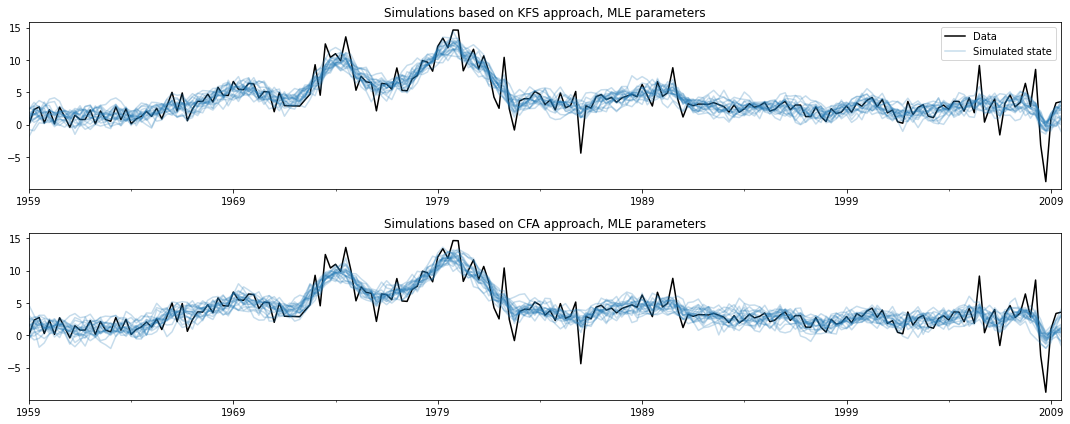

In [4]:
# Plot the inflation data along with simulated trends
fig, axes = plt.subplots(2, figsize=(15, 6))

# Plot data and KFS simulations
dta.infl.plot(ax=axes[0], color='k')
axes[0].set_title('Simulations based on KFS approach, MLE parameters')
simulated_state_kfs.plot(ax=axes[0], color='C0', alpha=0.25, legend=False)

# Plot data and CFA simulations
dta.infl.plot(ax=axes[1], color='k')
axes[1].set_title('Simulations based on CFA approach, MLE parameters')
simulated_state_cfa.plot(ax=axes[1], color='C0', alpha=0.25, legend=False)

# Add a legend, clean up layout
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[:2], ['Data', 'Simulated state'])
fig.tight_layout();

#### Updating the model's parameters

The simulation smoothers are tied to the model instance, here the variable `mod`. Whenever the model instance is updated with new parameters, the simulation smoothers will take those new parameters into account in future calls to the `simulate` method.

This is convenient for MCMC algorithms, which repeatedly (a) update the model's parameters, (b) draw a sample of the state vector, and then (c) draw new values for the model's parameters.

Here we will change the model to a different parameterization that yields a smoother trend, and show how the simulated values change (for brevity we only show the simulations from the KFS approach, but simulations from the CFA approach would be the same).

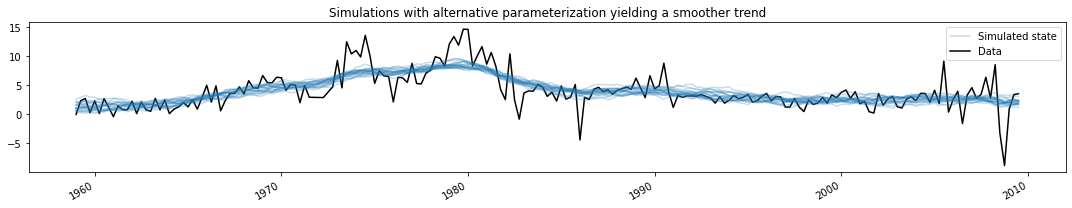

In [5]:
fig, ax = plt.subplots(figsize=(15, 3))

# Update the model's parameterization to one that attributes more
# variation in inflation to the observation error and so has less
# variation in the trend component
mod.update([4, 0.05])

# Plot simulations
for i in range(nsimulations):
    sim_kfs.simulate()
    ax.plot(dta.index, sim_kfs.simulated_state[0],
            color='C0', alpha=0.25, label='Simulated state')

# Plot data
dta.infl.plot(ax=ax, color='k', label='Data', zorder=-1)
    
# Add title, legend, clean up layout
ax.set_title('Simulations with alternative parameterization yielding a smoother trend')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:])
fig.tight_layout();

### Application: Bayesian analysis of a TVP-VAR model by MCMC

One of the applications that Chan and Jeliazkov (2009) consider is the time-varying parameters vector autoregression (TVP-VAR) model, estimated with Bayesian Gibb sampling (MCMC) methods. They apply this to model the co-movements in four macroeconomic time series:

- Real GDP growth
- Inflation
- Unemployment rate
- Short-term interest rates

We will replicate their example, using a very similar dataset that is included in Statsmodels.

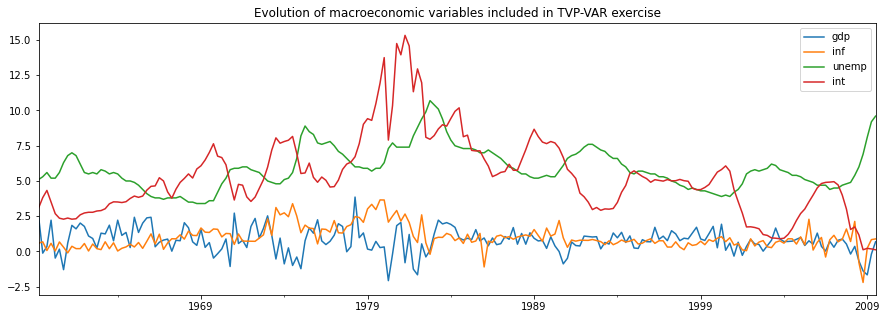

In [6]:
# Subset to the four variables of interest
y = dta[['realgdp', 'cpi', 'unemp', 'tbilrate']].copy()
y.columns = ['gdp', 'inf', 'unemp', 'int']

# Convert to real GDP growth and CPI inflation rates
y[['gdp', 'inf']] = np.log(y[['gdp', 'inf']]).diff() * 100
y = y.iloc[1:]

fig, ax = plt.subplots(figsize=(15, 5))
y.plot(ax=ax)
ax.set_title('Evolution of macroeconomic variables included in TVP-VAR exercise');

#### TVP-VAR model

**Note**: this section is based on Chan and Jeliazkov (2009) section 3.1, which can be consulted for additional details.

The usual (time-invariant) VAR(1) model is typically written:

$$
\begin{aligned}
y_t & = \mu + \Phi y_{t-1} + \varepsilon_t, \qquad \varepsilon_t \sim N(0, H)
\end{aligned}
$$

where $y_t$ is a $p \times 1$ vector of variables observed at time $t$ and $H$ is a covariance matrix.

The TVP-VAR(1) model generalizes this to allow the coefficients to vary over time according. Stacking all the parameters into a vector according to $\alpha_t = \text{vec}([\mu_t : \Phi_t])$, where $\text{vec}$ denotes the operation that stacks columns of a matrix into a vector, we model their evolution over time according to:

$$\alpha_{i,t+1} = \alpha_{i, t} + \eta_{i,t}, \qquad \eta_{i, t} \sim N(0, \sigma_i^2)$$

In other words, each parameter evolves independently according to a random walk.

Note that there are $p$ coefficients in $\mu_t$ and $p^2$ coefficients in $\Phi_t$, so the full state vector $\alpha$ is shaped $p * (p + 1) \times 1$.

Putting the TVP-VAR(1) model into state-space form is relatively straightforward, and in fact we just have to re-write the observation equation into SUR form:

$$
\begin{aligned}
y_t & = Z_t \alpha_t + \varepsilon_t, \qquad \varepsilon_t \sim N(0, H) \\
\alpha_{t+1} & = \alpha_t + \eta_t, \qquad \eta_t \sim N(0, \text{diag}(\{\sigma_i^2\}))
\end{aligned}
$$

where

$$
Z_t = \begin{bmatrix}
1 & y_{t-1}' & 0 & \dots & &  0 \\
0 & 0 & 1 & y_{t-1}' &  & 0 \\
\vdots & & & \ddots & \ddots & \vdots \\
0 & 0 & 0 & 0 & 1 & y_{t-1}'  \\
\end{bmatrix}
$$

As long as $H$ is full rank and each of the variances $\sigma_i^2$ is non-zero, the model satisfies the requirements of the CFA simulation smoother.

We also need to specify the initialization / prior for the initial state, $\alpha_1$. Here we will follow Chan and Jeliazkov (2009) in using $\alpha_1 \sim N(0, 5 I)$, although we could also model it as diffuse.

Aside from the time-varying coefficients $\alpha_t$, the other parameters that we will need to estimate are terms in the covariance matrix $H$ and the random walk variances $\sigma_i^2$.

#### TVP-VAR model in Statsmodels

Constructing this model programatically in Statsmodels is also relatively straightforward, since there are basically four steps:

1. Create a new `TVPVAR` class as a subclass of `sm.tsa.statespace.MLEModel`
2. Fill in the fixed values of the state space system matrices
3. Specify the initialization of $\alpha_1$
4. Create a method for updating the state space system matrices with new values of the covariance matrix $H$ and the random walk variances $\sigma_i^2$.

To do this, first note that the general state space representation used by Statsmodels is:

$$
\begin{aligned}
y_t & = d_t + Z_t \alpha_t + \varepsilon_t, \qquad \varepsilon_t \sim N(0, H_t) \\
\alpha_{t+1} & = c_t + T_t \alpha_t + R_t \eta_t, \qquad \eta_t \sim N(0, Q_t) \\
\end{aligned}
$$

Then the TVP-VAR(1) model implies the following specializations:

- The intercept terms are zero, i.e. $c_t = d_t = 0$
- The design matrix $Z_t$ is time-varying but its values are fixed as described above (i.e. its values contain ones and lags of $y_t$)
- The observation covariance matrix is not time-varying, i.e. $H_t = H_{t+1} = H$
- The transition matrix is not time-varying and is equal to the identity matrix, i.e. $T_t = T_{t+1} = I$
- The selection matrix $R_t$ is not time-varying and is also equal to the identity matrix, i.e. $R_t = R_{t+1} = I$
- The state covariance matrix $Q_t$ is not time-varying and is diagonal, i.e. $Q_t = Q_{t+1} = \text{diag}(\{\sigma_i^2\})$

In [7]:
# 1. Create a new TVPVAR class as a subclass of sm.tsa.statespace.MLEModel
class TVPVAR(sm.tsa.statespace.MLEModel):
    # Steps 2-3 are best done in the class "constructor", i.e. the __init__ method
    def __init__(self, y):
        # Create a matrix with [y_t' : y_{t-1}'] for t = 2, ..., T
        augmented = sm.tsa.lagmat(y, 1, trim='both', original='in', use_pandas=True)
        # Separate into y_t and z_t = [1 : y_{t-1}']
        p = y.shape[1]
        y_t = augmented.iloc[:, :p]
        z_t = sm.add_constant(augmented.iloc[:, p:])

        # Recall that the length of the state vector is p * (p + 1)
        k_states = p * (p + 1)
        super().__init__(y_t, exog=z_t, k_states=k_states)

        # Note that the state space system matrices default to contain zeros,
        # so we don't need to explicitly set c_t = d_t = 0.

        # Construct the design matrix Z_t
        # Notes:
        # -> self.k_endog = p is the dimension of the observed vector
        # -> self.k_states = p * (p + 1) is the dimension of the observed vector
        # -> self.nobs = T is the number of observations in y_t
        self['design'] = np.zeros((self.k_endog, self.k_states, self.nobs))
        for i in range(self.k_endog):
            start = i * (self.k_endog + 1)
            end = start + self.k_endog + 1
            self['design', i, start:end, :] = z_t.T

        # Construct the transition matrix T = I
        self['transition'] = np.eye(k_states)

        # Construct the selection matrix R = I
        self['selection'] = np.eye(k_states)

        # Step 3: Initialize the state vector as alpha_1 ~ N(0, 5I)
        self.ssm.initialize('known', stationary_cov=5 * np.eye(self.k_states))

    # Step 4. Create a method that we can call to update H and Q
    def update_variances(self, obs_cov, state_cov_diag):
        self['obs_cov'] = obs_cov
        self['state_cov'] = np.diag(state_cov_diag)

    # Finally, it can be convenient to define human-readable names for
    # each element of the state vector. These will be available in output
    @property
    def state_names(self):
        state_names = np.empty((self.k_endog, self.k_endog + 1), dtype=object)
        for i in range(self.k_endog):
            endog_name = self.endog_names[i]
            state_names[i] = (
                ['intercept.%s' % endog_name] +
                ['L1.%s->%s' % (other_name, endog_name) for other_name in self.endog_names])
        return state_names.ravel().tolist()

The above class defined the state space model for any given dataset. Now we need to create a specific instance of it with the dataset that we created earlier containing real GDP growth, inflation, unemployment, and interest rates.

In [8]:
# Create an instance of our TVPVAR class with our observed dataset y
mod = TVPVAR(y)

#### Preliminary investigation with ad-hoc parameters in H, Q

In our analysis below, we will need to begin our MCMC iterations with some initial parameterization. Following Chan and Jeliazkov (2009) we will set $H$ to be the sample covariance matrix of our dataset, and we will set $\sigma_i^2 = 0.01$ for each $i$.

Before discussing the MCMC scheme that will allow us to make inferences about the model, first we can consider the output of the model when simply plugging in these initial parameters. To fill in these parameters, we use the `update_variances` method that we defined earlier and then perform Kalman filtering and smoothing conditional on those parameters.

**Warning: This exercise is just by way of explanation - we must wait for the output of the MCMC exercise to study the actual implications of the model in a meaningful way**. 

In [9]:
initial_obs_cov = np.cov(y.T)
initial_state_cov_diag = [0.01] * mod.k_states

# Update H and Q
mod.update_variances(initial_obs_cov, initial_state_cov_diag)

# Perform Kalman filtering and smoothing
# (the [] is just an empty list that in some models might contain
# additional parameters. Here, we don't have any additional parameters
# so we just pass an empty list)
initial_res = mod.smooth([])

The `initial_res` variable contains the output of Kalman filtering and smoothing, conditional on those initial parameters. In particular, we may be interested in the "smoothed states", which are $E[\alpha_t \mid y^t, H, \{\sigma_i^2\}]$.

First, lets create a function that graphs the coefficients over time, separated into the equations for equation of the observed variables.

In [10]:
def plot_coefficients_by_equation(states):
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))

    # The way we defined Z_t implies that the first 5 elements of the
    # state vector correspond to the first variable in y_t, which is GDP growth
    ax = axes[0, 0]
    states.iloc[:, :5].plot(ax=ax)
    ax.set_title('GDP growth')
    ax.legend()

    # The next 5 elements correspond to inflation
    ax = axes[0, 1]
    states.iloc[:, 5:10].plot(ax=ax)
    ax.set_title('Inflation rate')
    ax.legend();

    # The next 5 elements correspond to unemployment
    ax = axes[1, 0]
    states.iloc[:, 10:15].plot(ax=ax)
    ax.set_title('Unemployment equation')
    ax.legend()

    # The last 5 elements correspond to the interest rate
    ax = axes[1, 1]
    states.iloc[:, 15:20].plot(ax=ax)
    ax.set_title('Interest rate equation')
    ax.legend();
    
    return ax


Now, we are interested in the smoothed states, which are available in the `states.smoothed` attribute out our results object `initial_res`.

As the graph below shows, the initial parameterization implies substantial time-variation in some of the coefficients.

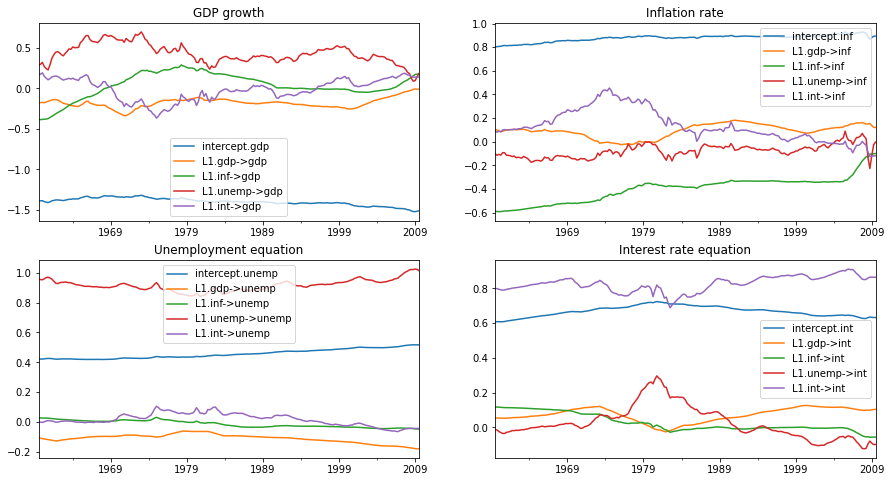

In [11]:
# Here, for illustration purposes only, we plot the time-varying
# coefficients conditional on an ad-hoc parameterization

# Recall that `initial_res` contains the Kalman filtering and smoothing,
# and the `states.smoothed` attribute contains the smoothed states
plot_coefficients_by_equation(initial_res.states.smoothed);

#### Bayesian estimation via MCMC

We will now implement the Gibbs sampler scheme described in Chan and Jeliazkov (2009), Algorithm 2.


We use the following (conditionally conjugate) priors:

$$
\begin{aligned}
H & \sim \mathcal{IW}(\nu_1^0, S_1^0) \\
\sigma_i^2 & \sim \mathcal{IG} \left ( \frac{\nu_{i2}^0}{2}, \frac{S_{i2}^0}{2} \right )
\end{aligned}
$$

where $\mathcal{IW}$ denotes the inverse-Wishart distribution and $\mathcal{IG}$ denotes the inverse-Gamma distribution. We set the prior hyperparameters as:

$$
\begin{aligned}
v_1^0 = T + 3, & \quad S_1^0 = I \\
v_{i2}^0 = 6, & \quad S_{i2}^0 = 0.01 \qquad \text{for each} ~ i\\
\end{aligned}
$$

In [12]:
# Prior hyperparameters

# Prior for obs. cov. is inverse-Wishart(v_1^0=k + 3, S10=I)
v10 = mod.k_endog + 3
S10 = np.eye(mod.k_endog)

# Prior for state cov. variances is inverse-Gamma(v_{i2}^0 / 2 = 3, S+{i2}^0 / 2 = 0.005)
vi20 = 6
Si20 = 0.01

Before running the MCMC iterations, there are a couple of practical steps:

1. Create arrays to store the draws of our state vector, observation covariance matrix, and state error variances.
2. Put the initial values for H and Q (described above) into the storage vectors
3. Construct the simulation smoother object associated with our `TVPVAR` instance to make draws of the state vector

In [13]:
# Gibbs sampler setup
niter = 11000
nburn = 1000

# 1. Create storage arrays
store_states = np.zeros((niter + 1, mod.nobs, mod.k_states))
store_obs_cov = np.zeros((niter + 1, mod.k_endog, mod.k_endog))
store_state_cov = np.zeros((niter + 1, mod.k_states))

# 2. Put in the initial values
store_obs_cov[0] = initial_obs_cov
store_state_cov[0] = initial_state_cov_diag
mod.update_variances(store_obs_cov[0], store_state_cov[0])

# 3. Construct posterior samplers
sim = mod.simulation_smoother(method='cfa')

As before, we could have used either the simulation smoother based on the Kalman filter and smoother or that based on the Cholesky Factor Algorithm.

In [14]:
for i in range(niter):
    mod.update_variances(store_obs_cov[i], store_state_cov[i])
    sim.simulate()

    # 1. Sample states
    store_states[i + 1] = sim.simulated_state.T

    # 2. Simulate obs cov
    fitted = np.matmul(mod['design'].transpose(2, 0, 1), store_states[i + 1][..., None])[..., 0]
    resid = mod.endog - fitted
    store_obs_cov[i + 1] = invwishart.rvs(v10 + mod.nobs, S10 + resid.T @ resid)

    # 3. Simulate state cov variances
    resid = store_states[i + 1, 1:] - store_states[i + 1, :-1]
    sse = np.sum(resid**2, axis=0)
    
    for j in range(mod.k_states):
        rv = invgamma.rvs((vi20 + mod.nobs - 1) / 2, scale=(Si20 + sse[j]) / 2)
        store_state_cov[i + 1, j] = rv

After removing a number of initial draws, the remaining draws from the posterior allow us to conduct inference. Below, we plot the posterior mean of the time-varying regression coefficients.

(**Note**: these plots are different from those in Figure 1 of the published version of Chan and Jeliazkov (2009), but they are very similar to those produced by the Matlab replication code available at http://joshuachan.org/code/code_TVPVAR.html)

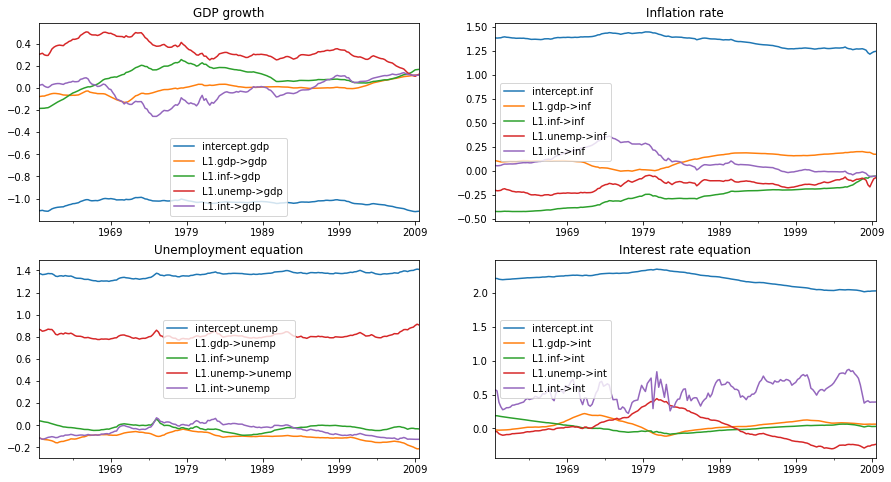

In [15]:
# Collect the posterior means of each time-varying coefficient
states_posterior_mean = pd.DataFrame(
    np.mean(store_states[nburn + 1:], axis=0),
    index=mod._index, columns=mod.state_names)

# Plot these means over time
plot_coefficients_by_equation(states_posterior_mean);

Python also has a number of libraries to assist with exploring Bayesian models. Here we'll just use the [arviz](https://arviz-devs.github.io/arviz/index.html) package to explore the credible intervals of each of the covariance and variance parameters, although it makes available a much wider set of tools for analysis.

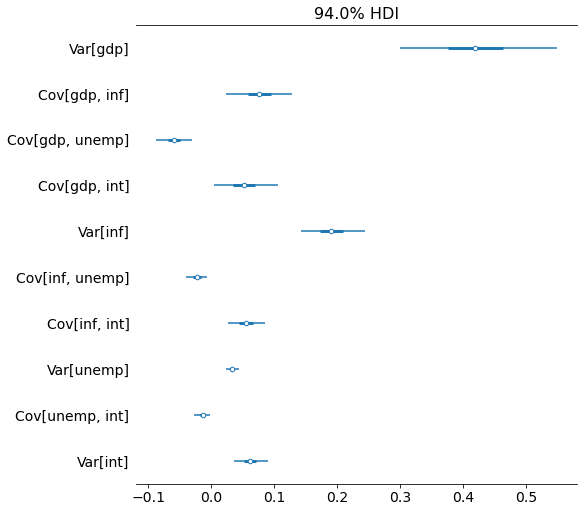

In [16]:
import arviz as az

# Collect the observation error covariance parameters
az_obs_cov = az.convert_to_inference_data({
    ('Var[%s]' % mod.endog_names[i] if i == j else
     'Cov[%s, %s]' % (mod.endog_names[i], mod.endog_names[j])):
    store_obs_cov[nburn + 1:, i, j]
    for i in range(mod.k_endog) for j in range(i, mod.k_endog)})

# Plot the credible intervals
az.plot_forest(az_obs_cov, figsize=(8, 7));

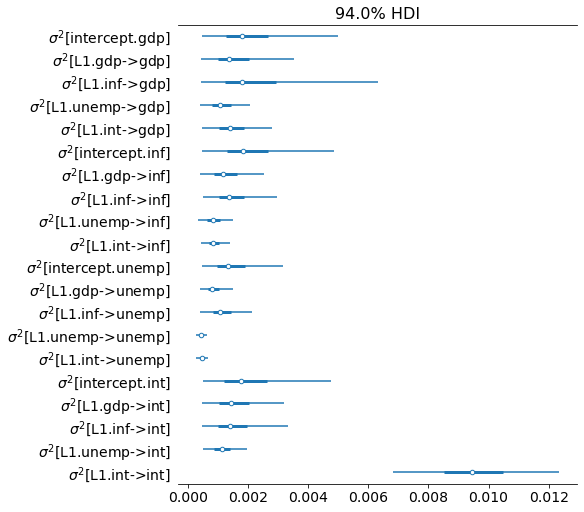

In [17]:
# Collect the state innovation variance parameters
az_state_cov = az.convert_to_inference_data({
    r'$\sigma^2$[%s]' % mod.state_names[i]: store_state_cov[nburn + 1:, i]
    for i in range(mod.k_states)})

# Plot the credible intervals
az.plot_forest(az_state_cov, figsize=(8, 7));

### Appendix: performance

Finally, we run a few simple tests to compare the performance of the KFS and CFA simulation smoothers by using the `%timeit` Jupyter notebook magic.

One caveat is that the KFS simulation smoother can produce a variety of output beyond just simulations of the posterior state vector, and these additional computations could bias the results. To make the results comparable, we will tell the KFS simulation smoother to only compute simulations of the state by using the `simulation_output` argument.

In [18]:
from statsmodels.tsa.statespace.simulation_smoother import SIMULATION_STATE

sim_cfa = mod.simulation_smoother(method='cfa')
sim_kfs = mod.simulation_smoother(simulation_output=SIMULATION_STATE)

Then we can use the following code to perform a basic timing exercise:

```python
%timeit -n 10000 -r 3 sim_cfa.simulate()
%timeit -n 10000 -r 3 sim_kfs.simulate()
```

On the machine this was tested on, this resulted in the following:

```
2.06 ms ± 26.5 µs per loop (mean ± std. dev. of 3 runs, 10000 loops each)
2.02 ms ± 68.4 µs per loop (mean ± std. dev. of 3 runs, 10000 loops each)
```

These results suggest that - at least for this model - there are not noticeable computational gains from the CFA approach relative to the KFS approach. However, this does not rule out the following:

1. The Statsmodels implementation of the CFA simulation smoother could possibly be further optimized
2. The CFA approach may only show improvement for certain models (for example with a large number of `endog` variables)

One simple way to take a first pass at assessing the first possibility is to compare the runtime of the Statsmodels implementation of the CFA simulation smoother to the Matlab implementation in the replication codes of Chan and Jeliazkov (2009), available at http://joshuachan.org/code/code_TVPVAR.html.

While the Statsmodels version of the CFA simulation smoother is written in Cython and compiled to C code, the Matlab version takes advantage of the Matlab's sparse matrix capabilities. As a result, even though it is not compiled code,  we might expect it to have relatively good performance.

On the machine this was tested on, the Matlab version typically ran the MCMC loop with 11,000 iterations in 70-75 seconds, while the MCMC loop in this notebook using the Statsmodels CFA simulation smoother (see above), also with 11,000 iterations, ran in 40-45 seconds. This is some evidence that the Statsmodels implementation of the CFA smoother already performs relatively well (although it does not rule out that there are additional gains possible).

### References

Carter, Chris K., and Robert Kohn. "On Gibbs sampling for state space models." Biometrika 81, no. 3 (1994): 541-553.

Chan, Joshua CC, and Ivan Jeliazkov. "Efficient simulation and integrated likelihood estimation in state space models." International Journal of Mathematical Modelling and Numerical Optimisation 1, no. 1-2 (2009): 101-120.

De Jong, Piet, and Neil Shephard. "The simulation smoother for time series models." Biometrika 82, no. 2 (1995): 339-350.

Durbin, James, and Siem Jan Koopman. "A simple and efficient simulation smoother for state space time series analysis." Biometrika 89, no. 3 (2002): 603-616.

McCausland, William J., Shirley Miller, and Denis Pelletier. "Simulation smoothing for state–space models: A computational efficiency analysis." Computational Statistics & Data Analysis 55, no. 1 (2011): 199-212.